In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
import seaborn as sns
from sklearn.metrics import confusion_matrix, log_loss, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
RANDOM_SEED = 0

## Data exploration

In [3]:
application = pd.read_csv("application_record.csv")
application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
application.shape

(438557, 18)

In [5]:
credit = pd.read_csv("credit_record.csv")
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [6]:
credit.shape

(1048575, 3)

Ricerca ID unici

In [7]:
len(set(application['ID']))

438510

In [8]:
len(set(credit['ID']))

45985

quanti id in comune?

In [9]:
len(set(application['ID']).intersection(set(credit['ID'])))

36457

In [10]:
#quindi 36457 clienti hanno ottenuto la carta di credito hanno delle info

## Preprocessing

### Creazione variabile target

nel dataset credit, se un cliente ha avuto almeno il valore 2, allora è classificato come "bad customer" (1), altrimenti è un buon customer (0) nella colonna QUALITY

In [11]:

# colonna QUALITY
credit['QUALITY'] = credit['STATUS'].apply(lambda x: 1 if x in ["2","3","4","5"] else 0)

# Raggruppa il DataFrame 'credit' per 'ID' e calcola la somma della colonna 'quality'
credit_grouped = credit.groupby('ID')['QUALITY'].sum().reset_index()

# Unisci i DataFrame 'application' e 'credit_grouped' utilizzando 'ID' come chiave
df = pd.merge(application, credit_grouped, on='ID', how='inner')

# Modifica la colonna 'quality' in modo che abbia il valore 1 se la somma è maggiore di 0, altrimenti 0
df['QUALITY'] = df['QUALITY'].apply(lambda x: 1 if x > 0 else 0)


In [12]:
df.shape

(36457, 19)

In [13]:
df["QUALITY"].value_counts() # variabile target molto squilibrata

0    35841
1      616
Name: QUALITY, dtype: int64

### Trasformazione di tutte le variabili categoriche in numeriche

In [14]:
df.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
QUALITY                  int64
dtype: object

In [15]:
def number_map(df, column, map_type):
    df[column] = df[column].map(map_type)
    print(df[column].value_counts())

In [16]:
gender_map = {"F":0, "M":1}
number_map(df, "CODE_GENDER", gender_map)

0    24430
1    12027
Name: CODE_GENDER, dtype: int64


In [17]:
y_n_map = {"N":0, "Y":1}
number_map(df, "FLAG_OWN_CAR", y_n_map)

0    22614
1    13843
Name: FLAG_OWN_CAR, dtype: int64


In [18]:
number_map(df, "FLAG_OWN_REALTY", y_n_map)

1    24506
0    11951
Name: FLAG_OWN_REALTY, dtype: int64


In [19]:
work_map = {"Student":0, "State servant":1, "Pensioner":2, "Commercial associate":3, "Working":4}
number_map(df, "NAME_INCOME_TYPE", work_map)

4    18819
3     8490
2     6152
1     2985
0       11
Name: NAME_INCOME_TYPE, dtype: int64


In [20]:
education_map = {"Academic degree":0, "Lower secondary":1, "Incomplete higher":2, "Higher education":3, "Secondary / secondary special":4}
number_map(df, "NAME_EDUCATION_TYPE", education_map)

4    24777
3     9864
2     1410
1      374
0       32
Name: NAME_EDUCATION_TYPE, dtype: int64


In [21]:
family_map = {"Widow":0, "Separated":1, "Civil marriage":2, "Single / not married":3, "Married":4}
number_map(df, "NAME_FAMILY_STATUS", family_map)

4    25048
3     4829
2     2945
1     2103
0     1532
Name: NAME_FAMILY_STATUS, dtype: int64


In [22]:
housing_map = {"Co-op apartment":0, "Office apartment":1, "Rented apartment":2, "Municipal apartment":3, "With parents":4, "House / apartment":5}
number_map(df, "NAME_HOUSING_TYPE", housing_map)

5    32548
4     1776
3     1128
2      575
1      262
0      168
Name: NAME_HOUSING_TYPE, dtype: int64


In [23]:
df["OCCUPATION_TYPE"].value_counts()

Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: OCCUPATION_TYPE, dtype: int64

In [24]:
#troppe variabili per creare un dizionario, uso label encoder
le = LabelEncoder()
df["OCCUPATION_TYPE"] = le.fit_transform(df["OCCUPATION_TYPE"])

In [25]:
df["OCCUPATION_TYPE"] = df["OCCUPATION_TYPE"].replace(18, np.nan)

In [26]:
df["OCCUPATION_TYPE"].value_counts()

8.0     6211
3.0     3591
14.0    3485
10.0    3012
4.0     2138
6.0     1383
0.0     1241
11.0    1207
2.0      655
16.0     592
1.0      551
12.0     344
9.0      175
17.0     174
15.0     151
5.0       85
13.0      79
7.0       60
Name: OCCUPATION_TYPE, dtype: int64

In [27]:
X = df.drop(["QUALITY","ID"], axis=1).values
y = df["QUALITY"].values

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=RANDOM_SEED)

### data imputation

In [29]:
imp = SimpleImputer()
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

### standardizzazione

In [30]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### feature selection

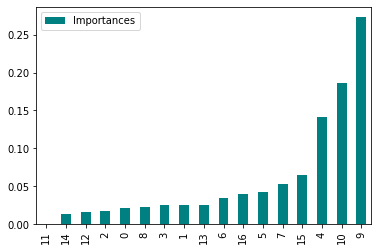

               Features  Importances
11           FLAG_MOBIL     0.000000
14           FLAG_EMAIL     0.013088
12      FLAG_WORK_PHONE     0.016351
2       FLAG_OWN_REALTY     0.017582
0           CODE_GENDER     0.021491
8     NAME_HOUSING_TYPE     0.022106
3          CNT_CHILDREN     0.024565
1          FLAG_OWN_CAR     0.025442
13           FLAG_PHONE     0.025462
6   NAME_EDUCATION_TYPE     0.034554
16      CNT_FAM_MEMBERS     0.039244
5      NAME_INCOME_TYPE     0.041940
7    NAME_FAMILY_STATUS     0.052944
15      OCCUPATION_TYPE     0.064384
4      AMT_INCOME_TOTAL     0.141078
10        DAYS_EMPLOYED     0.186341
9            DAYS_BIRTH     0.273427


In [31]:
# riprendo i nomi delle colonne
col_names = df.drop(["QUALITY","ID"], axis=1).columns

model = RandomForestClassifier()
model.fit(X_train, y_train)
importances = model.feature_importances_
final_df = pd.DataFrame({"Features": col_names, "Importances": importances})
final_df.set_index("Importances")
final_df = final_df.sort_values("Importances")
final_df.plot.bar(color = "teal")
plt.show()

print(final_df)

### VIF

In [32]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif["features"] = col_names
vif.round(1)
# no autocorrelazione

C:\Users\orizi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,VIF Factor,features
0,1.2,CODE_GENDER
1,1.2,FLAG_OWN_CAR
2,1.1,FLAG_OWN_REALTY
3,7.8,CNT_CHILDREN
4,1.2,AMT_INCOME_TOTAL
5,1.4,NAME_INCOME_TYPE
6,1.1,NAME_EDUCATION_TYPE
7,1.9,NAME_FAMILY_STATUS
8,1.0,NAME_HOUSING_TYPE
9,1.9,DAYS_BIRTH


## Modellazione

### SVC

In [36]:
svc = SVC()

In [37]:
def perform_grid_search(model, X_train, y_train):
    # griglia di parametri da testare
    param_grid = {'kernel':('linear', 'rbf'), 'C':[0.1, 1], 'gamma':[0.1, 1]}
    grid = GridSearchCV(model, param_grid, scoring='recall', cv=5)
    # fit
    grid.fit(X_train, y_train)
    # migliori parametri
    print(grid.best_params_)

In [38]:
perform_grid_search(svc, X_train, y_train)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [39]:
svc = SVC(kernel="rbf", C=1, gamma=1, probability=True)

In [40]:
svc.fit(X_train, y_train)

SVC(C=1, gamma=1, probability=True)

In [41]:
#matrice confusione
def plot_confusion_matrix(y_true, y_pred, labels = ["Negative", "Positive"], show_precision_recall=False):

    cm = confusion_matrix(y_true, y_pred)

    df_cm = pd.DataFrame(cm, index=labels,
                         columns=["Predicted "+labels[0], "Predicted "+labels[1]])

    sns.heatmap(df_cm, annot=True, fmt="g")

    if show_precision_recall:
        plt.text(0, -0.1, f"Precision: {cm[1][1]/(cm[1][1]+cm[0][1]):.3f}")
        plt.text(1, -0.1, f"Recall: {cm[1][1]/(cm[1][1]+cm[1][0]):.3f}")


In [42]:
def classification_log_loss_report(model, data, log = False):
    X, y = data
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    report = classification_report(y, y_pred)
    log = log_loss(y, y_proba)
    print(report)

    if log:
        print(f"log_loss: {log}")

In [43]:
classification_log_loss_report(svc, (X_train, y_train), log=True)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     25070
           1       0.86      0.26      0.40       449

    accuracy                           0.99     25519
   macro avg       0.92      0.63      0.70     25519
weighted avg       0.98      0.99      0.98     25519

log_loss: 0.06803656918535768


In [44]:
classification_log_loss_report(svc, (X_test, y_test), log=True)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10771
           1       0.35      0.08      0.13       167

    accuracy                           0.98     10938
   macro avg       0.67      0.54      0.56     10938
weighted avg       0.98      0.98      0.98     10938

log_loss: 0.07548189939531547


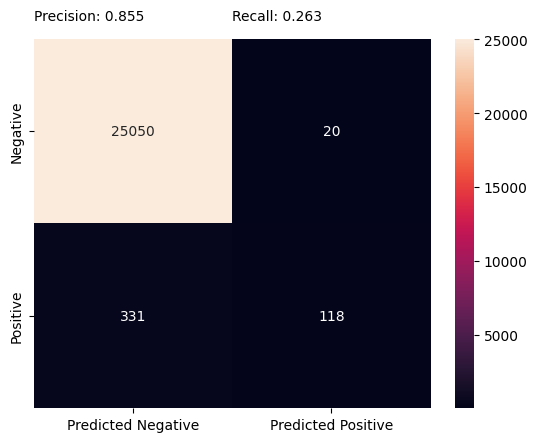

In [45]:
plot_confusion_matrix(y_train, svc.predict(X_train), show_precision_recall=True)

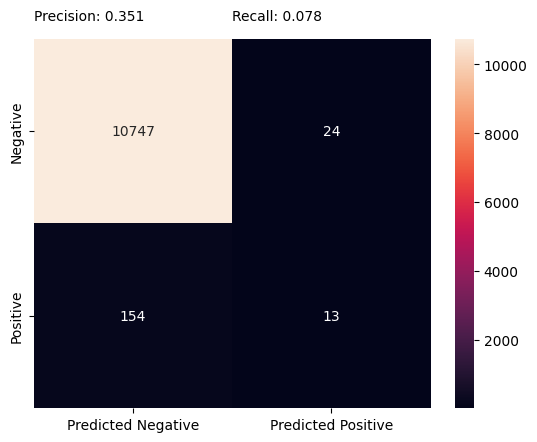

In [46]:
plot_confusion_matrix(y_test, svc.predict(X_test), show_precision_recall=True)

#### smote + svc

In [47]:
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
pd.DataFrame(y_train_res).value_counts()

0    25070
1    25070
dtype: int64

In [48]:
svc_smote = SVC()

In [49]:
#perform_grid_search(svc_smote, X_train_res, y_train_res)
#stesso risultato

In [50]:
svc_smote = SVC(kernel="rbf", C=1, gamma=1, probability=True)
svc_smote.fit(X_train_res, y_train_res)

SVC(C=1, gamma=1, probability=True)

In [51]:
classification_log_loss_report(svc_smote, (X_train_res, y_train_res), log=True)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     25070
           1       0.95      0.99      0.97     25070

    accuracy                           0.97     50140
   macro avg       0.97      0.97      0.97     50140
weighted avg       0.97      0.97      0.97     50140

log_loss: 0.09681389062539433


In [52]:
classification_log_loss_report(svc_smote, (X_test, y_test), log=True)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     10771
           1       0.11      0.43      0.17       167

    accuracy                           0.94     10938
   macro avg       0.55      0.69      0.57     10938
weighted avg       0.98      0.94      0.96     10938

log_loss: 0.17478345714825866


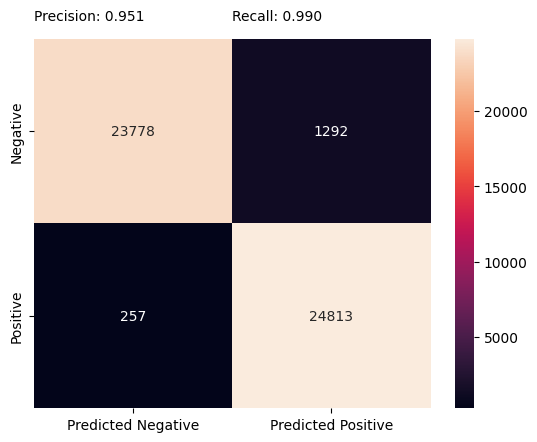

In [53]:
plot_confusion_matrix(y_train_res, svc_smote.predict(X_train_res), show_precision_recall=True)

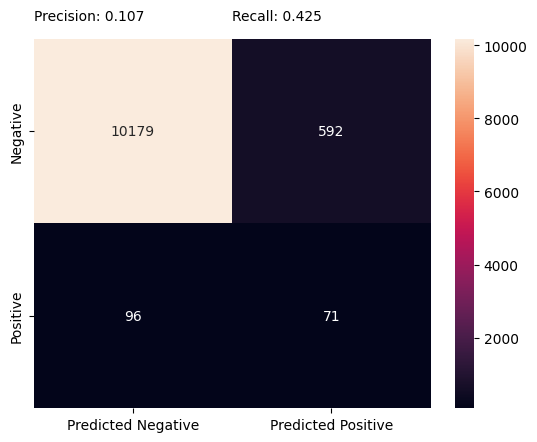

In [54]:
plot_confusion_matrix(y_test, svc_smote.predict(X_test), show_precision_recall=True)

### MLP

In [55]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100), random_state=RANDOM_SEED)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 100, 100), random_state=0)

In [56]:
classification_log_loss_report(mlp, (X_train, y_train),log=True)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     25070
           1       0.74      0.59      0.66       449

    accuracy                           0.99     25519
   macro avg       0.87      0.79      0.83     25519
weighted avg       0.99      0.99      0.99     25519

log_loss: 0.02562963421383632


In [57]:
classification_log_loss_report(mlp, (X_test, y_test),log=True)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10771
           1       0.24      0.20      0.22       167

    accuracy                           0.98     10938
   macro avg       0.62      0.59      0.60     10938
weighted avg       0.98      0.98      0.98     10938

log_loss: 0.15372743171039382


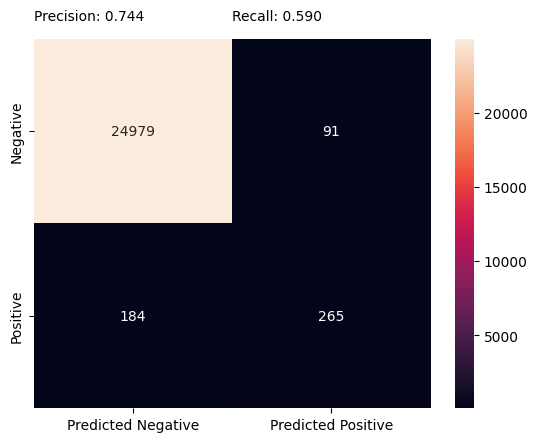

In [58]:
plot_confusion_matrix(y_train, mlp.predict(X_train), show_precision_recall=True)

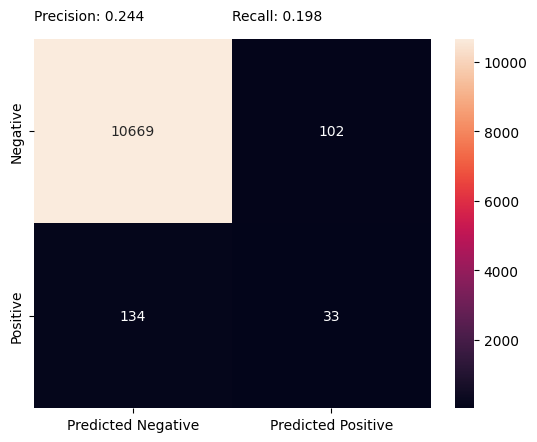

In [59]:
plot_confusion_matrix(y_test, mlp.predict(X_test), show_precision_recall=True)

#### smote + mlp

In [60]:
mlp_smote = MLPClassifier(hidden_layer_sizes=(100,100,100), random_state=RANDOM_SEED)
mlp_smote.fit(X_train_res, y_train_res)

MLPClassifier(hidden_layer_sizes=(100, 100, 100), random_state=0)

In [61]:
classification_log_loss_report(mlp_smote, (X_train, y_train),log=True)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     25070
           1       0.33      0.90      0.49       449

    accuracy                           0.97     25519
   macro avg       0.67      0.93      0.74     25519
weighted avg       0.99      0.97      0.97     25519

log_loss: 0.07293035407780696


In [62]:
classification_log_loss_report(mlp_smote, (X_test, y_test),log=True)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     10771
           1       0.13      0.38      0.20       167

    accuracy                           0.95     10938
   macro avg       0.56      0.67      0.59     10938
weighted avg       0.98      0.95      0.96     10938

log_loss: 0.29628941424849337


### Complement naive bayes (dovrebbe funzionare meglio con dataset sbilanciati)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=RANDOM_SEED)

#### data imputation

In [64]:
#data imputation
imp = SimpleImputer()
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

#### normalizzazione

In [65]:
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [66]:
comNB = ComplementNB()
comNB.fit(X_train, y_train)

ComplementNB()

In [67]:
classification_log_loss_report(comNB, (X_train, y_train),log=True)

              precision    recall  f1-score   support

           0       0.99      0.58      0.73     25070
           1       0.02      0.53      0.04       449

    accuracy                           0.58     25519
   macro avg       0.50      0.56      0.38     25519
weighted avg       0.97      0.58      0.72     25519

log_loss: 0.6849492284920063


In [68]:
classification_log_loss_report(comNB, (X_test, y_test), log=True)

              precision    recall  f1-score   support

           0       0.98      0.57      0.72     10771
           1       0.01      0.43      0.03       167

    accuracy                           0.56     10938
   macro avg       0.50      0.50      0.37     10938
weighted avg       0.97      0.56      0.71     10938

log_loss: 0.6863796422281709


### KNN

In [69]:
Ks = [1,2,3,4,5,10]

for K in Ks:

    print(f"K = {K}")

    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(X_train, y_train)

    y_pred_train = knn.predict(X_train)
    y_proba_train = knn.predict_proba(X_train)

    y_pred_test = knn.predict(X_test)
    y_proba_test = knn.predict_proba(X_test)

    print("Class Report TRAIN")
    print(classification_report(y_train, y_pred_train))
    print("Class Report TEST")
    print(classification_report(y_test, y_pred_test))


K = 1
Class Report TRAIN
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     25070
           1       0.64      0.63      0.63       449

    accuracy                           0.99     25519
   macro avg       0.81      0.81      0.81     25519
weighted avg       0.99      0.99      0.99     25519

Class Report TEST
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10771
           1       0.24      0.25      0.24       167

    accuracy                           0.98     10938
   macro avg       0.61      0.62      0.62     10938
weighted avg       0.98      0.98      0.98     10938

K = 2
Class Report TRAIN
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     25070
           1       0.81      0.19      0.31       449

    accuracy                           0.98     25519
   macro avg       0.90      0.60      0.65     25519
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [70]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [71]:
classification_log_loss_report(knn, (X_train, y_train),log=True)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     25070
           1       0.64      0.63      0.63       449

    accuracy                           0.99     25519
   macro avg       0.81      0.81      0.81     25519
weighted avg       0.99      0.99      0.99     25519

log_loss: 0.46468756475643835


In [72]:
classification_log_loss_report(knn, (X_test, y_test),log=True)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10771
           1       0.24      0.25      0.24       167

    accuracy                           0.98     10938
   macro avg       0.61      0.62      0.62     10938
weighted avg       0.98      0.98      0.98     10938

log_loss: 0.8402936198779372


In [73]:
knn_smote = KNeighborsClassifier(n_neighbors=1)
knn_smote.fit(X_train_res, y_train_res)

KNeighborsClassifier(n_neighbors=1)

In [74]:
classification_log_loss_report(knn_smote, (X_train_res, y_train_res),log=True)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     25070
           1       0.99      0.94      0.97     25070

    accuracy                           0.97     50140
   macro avg       0.97      0.97      0.97     50140
weighted avg       0.97      0.97      0.97     50140

log_loss: 1.1818062658896813


In [75]:
classification_log_loss_report(knn_smote, (X_test, y_test),log=True)

              precision    recall  f1-score   support

           0       0.99      0.77      0.86     10771
           1       0.02      0.28      0.03       167

    accuracy                           0.76     10938
   macro avg       0.50      0.52      0.45     10938
weighted avg       0.97      0.76      0.85     10938

log_loss: 8.71928203214518


## Conclusione

I miei modelli avevano come scopo individuare, al meglio delle loro possibilità, i "bad customers"; in modo tale da prendere provvedimenti su quei clienti, accettando che alcuni "good customers" vengano classificati male.
In altre parole cerco una recall del target = 1 più alta possibile nel test set, per questo scopo il modello SVC aiutato dalla tecnica SMOTE si è dimostrato il miglior modello tra quelli testati
